***Pruebas para la determinación de normalidad en los datos medidos intralaboratorio*** 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Bibliotecas 

Se importan las bibliotecas necesarias para el analisis de los datos 

In [2]:
!pip install pingouin ## Se instala manualmente esta biblioteca

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=1336fd963104b2fec3472fd6caab91a1e800c0ab4de103ce03ed2f317065eafd
  Stored in directory: /root/.cache/pip/wheels/04/bb/0d/2d02ec45f29c48d6192476bfb59c5a0e64b605e7212374dd15
Successfully built littleutils


In [3]:
import numpy as np ## Manipulación matematica 
import pandas as pd ## Manipulación de conjuntos de datos 
from scipy import stats ## Invocar funciones estadisticas 
from sklearn.linear_model import LinearRegression ## Generar un modelo de regresión lineal 
import matplotlib.pyplot as plt ## Imprimir graficas (Regresión linela)
from statsmodels.stats.stattools import durbin_watson ## Modelo durbin watson para la verificación de independencia de residuos 
import pingouin as pg ## Resultados estadisiticos 
from scipy.stats import mannwhitneyu

## Carga de los datos

En esta sección se carga, primero el excel, que contiene los datos intralaboratorio, y se especifica, las mediciones de los dos participantes 

Se cargan los datos a los cuales se pretende realizar las pruebas de normalidad

In [4]:
def numeric_columns(matriz_data):
    matriz_data_c = matriz_data
    for i in matriz_data_c.columns[1:]:
        matriz_data_c[i] = matriz_data_c[i].astype(float) 
    return matriz_data_c

In [5]:
comparacion_intra_lab = '/content/drive/MyDrive/Análisis estadístico  Dishegro/Prueba intra-laboratorio/Analisis estadistico/DS05-F04 008  2022 Par torsional.xlsm' ## Se define la dirección en donde se encuentra el documento 
int_lab = pd.read_excel(comparacion_intra_lab, sheet_name = 'DC05-F04 Intralaboratorio') ## con la función read_excel se lee la dirección, la entrada sheet_name nos especifica que hoja se quiere leer 


Se genera la tabla que almacena los puntos de medicón con sus respectivos operarios

In [6]:
puntos_de_medición = pd.DataFrame(int_lab.iloc[25:32,0:4]) ## definimos la tabla que contiene las mediciones a analizar 
puntos_de_medición.columns = ['Nombre','1 punto de medición','2 punto de medición','3 punto de medición'] ## Se convierten en Dataframe para manipular mejor y se le agrega nombre a cada columna

In [7]:
puntos_de_medición = puntos_de_medición.reset_index()## Resetea el indice para que no quede con el indice del Excel
puntos_de_medición = puntos_de_medición.drop([0],axis = 0) ## Borra las filas del indice anterior 
puntos_de_medición = puntos_de_medición.drop(['index'],axis = 1) ## Borra la columna de indice 

Se realiza un dataframe de las mediciones por los dos operarios 

In [8]:
puntos_de_medición.iloc[:3,0] = 'Operario 1' ## Definir las mediciones del operario 1
puntos_de_medición.iloc[3:,0] = 'Operario 2' ## Definir las mediciones del operario2 
puntos_de_medición

,Nombre,1 punto de medición,2 punto de medición,3 punto de medición
1,Operario 1,3.7536,6.0975,5.424
2,Operario 1,3.4,6.0162,5.5596
3,Operario 1,3.128,5.8536,6.102
4,Operario 2,3.5904,5.8536,5.8308
5,Operario 2,3.9712,6.0975,7.8648
6,Operario 2,4.08,5.8536,7.8648


De los puntos de medida, se definen los dos operarios implicado en la prueba, en caso de requerir, las dos muestras por separado 


In [9]:
operario_1 = puntos_de_medición.loc[puntos_de_medición['Nombre'] == 'Operario 1'] ## Vector con las muestras del operario 1
operario_2 = puntos_de_medición.loc[puntos_de_medición['Nombre'] == 'Operario 2'] ## Vector con las muestras del operario 2

A pesar de definir especificamente cada la matriz para cada vector, considero que este proceso se puede realizar de forma mas automatizada, definiendo bien las posibles entradas, en otros documentos de excel 

## Funciones necesarias para realizar las pruebas de normalidad 

### Prueba de normalidad Shapiro Wilk 

Objetivo: La función tiene como objetivo, realizar la prueba en un Dataframe, cuyas columnas tengan los datos correspondientes a un punto de medición, cada una

Entrada: La entrada para la función es la matriz puntos de medición 

Procedimiento: Se crea una lista vacia, llamada sha_test, en esta lista se anexaran los resultados obtenidos de aplicar la prueba en cada punto.
Para aplicar la prueba en cada punto, se utiliza un ciclo for (list comprehension), que aplica la prueba en cada columna de la matriz, posterior a esto se crea un dataFrame con los resultados, devolviendo dicha lista  

Salida: Un Dataframe con los resultados estadisticos y p-valor para cada uno de los puntos de la matriz, resultado de aplicar Shapiro Wilk

Interpretación: El test de Shapiro-Wilks plantea la hipótesis nula de que una muestra proviene de una distribución normal. Eligimos un nivel de significanza, por ejemplo 0,05, y tenemos una hipótesis alternativa que sostiene que la distribución no es normal.

En conclusión si el p-valor de la prueba de Shapiro-Wilk es superior a 0,05, los datos son normales. Si está por debajo de 0,05, los datos se desvían significativamente de una distribución normal.

In [10]:
def shapiro_test(pts_med):
    sha_test = []
    sha_test = ([stats.shapiro(pts_med[i]) for i   in  pts_med.columns[1:]])
    sha_test  = pd.DataFrame(sha_test, index = pts_med.columns[1:])
    return sha_test

### Prueba de homoscedasticidad (Levene test)

Objetivo: La función tiene como objetivo, realizar la prueba de comparación entre dos Dataframes, cuyas columnas tengan los datos correspondientes a un punto de medición

Entrada: La entrada para la función son dos vectores con los puntos medidos para cada operario

Procedimiento: Se crea una lista vacia, llamada lev_test, en esta lista se anexaran los resultados obtenidos al comparar lo medido por cada operario por medio de la prueba en cada punto. Para aplicar la prueba en cada punto, se utiliza un ciclo for (list comprehension), que aplica la prueba en cada columna de la matriz, posterior a esto se crea un dataFrame con los resultados, devolviendo dicha lista

La función stats.levene, implica la especificación del estadistico a comparar, definida en la cariable center, dicha prueba tiene tres variaciones, explicadas a continuacion:

on posibles tres variaciones de la prueba de Levene. Las posibilidades y sus usos recomendados son:

'median' : Recomendado para distribuciones sesgadas (no normales)

'mean' : Recomendado para distribuciones simétricas de cola moderada.

'trimmed' : Recomendado para distribuciones de colas pesadas.

La versión de prueba que utiliza la media fue propuesta en el artículo original de Levene ( *Levene, H. (1960). En Contribuciones a la probabilidad y la estadística: ensayos en honor de Harold Hotelling, I. Olkin et al. eds., Stanford University Press, págs. 278-292.*), mientras que la mediana y la media recortada han sido estudiadas por Brown y Forsythe (*Brown, MB y Forsythe, AB (1974), Revista de la Asociación Estadounidense de Estadística, 69, 364-367*), a veces también denominada prueba de Brown-Forsythe.

En este caso se utiliza, el valor pre-determinado 'median', puesto que existen indicios de que la prueba no es normal de acuerdo a lo anteriormente obtenido en la función de shapiro wilk

Salida: Un Dataframe con los resultados estadisticos y p-valor para cada uno de los puntos de la matriz, resultado de aplicar Levene test

La prueba se usa para probar si k muestras tienen varianzas iguales. La igualdad de varianzas entre muestras se denomina homogeneidad de varianza. Algunas pruebas estadísticas, por ejemplo, el análisis de varianza, suponen que las varianzas son iguales entre grupos o muestras. La prueba de Levene se puede utilizar para verificar esa suposición.

Se considera como hipótesis nula que los datos proceden de distribuciones con la misma varianza (homocedasticidad). ***Por lo tanto, si el p-value es menor que un determinado valor (típicamente 0.05), entonces se considera que hay evidencias suficientes para rechazar la homocedasticidad en favor de la heterocedasticidad.***

In [11]:
def levene_test(pts_med1,pts_med2):
    lev_test = []
    lev_test = [stats.levene(pts_med1[i], pts_med2[i], center='median') for i in   operario_2.columns[1:]]
    lev_test  = pd.DataFrame(lev_test, index = pts_med1.columns[1:])
    return lev_test

### Independencia de residuos 

Objetivo: La función tiene como objetivo, realizar y graficar la regresión lineal para cada una de los puntos de medición, posteriormente obtener los residuos y aplicar prueba de independencia sobre estos 

Entrada: La entrada para la función es la matriz puntos de medición, esto en caso de la función que permite el ciclo for, sin embargo para la función regresión linel, la entrada es las muestras para cada punto (las columnas de la matrix)

Procedimiento: Se crea un vector x, que enumerara los puntos de cada muestra, se prepara luego el modelo de función lineal, para posteriormente involucrar dicha x y los puntos de medición, con el fin de predecir unos puntos, producto del modelo de refresion lineal, finalemnte se restan los puntos originales y los obtenidos por el modelo, para asi tener los residuos, dichos residuos se le aplica la función durbin_watson, para obtener el estadistico correspondiente 

Salida, se obtiene un dataFrame con el estadistico de Durbin Watson en cada punto

Interpretación: La prueba de Durbin-Watson, se utiliza para detectar la presencia de autocorrelación en los residuos de una regresión, en otras palabras para corroborar independencia de residuos 


La estadística de prueba siempre varía de 0 a 4 donde:

* d = 2 indica que no hay autocorrelación
* d <2 indica correlación serial positiva
* d > 2 indica correlación serial negativa

In [50]:
def regresión_lineal(pt_med,i,m,fig, ax):
    x = np.array(range(len(pt_med)))
    regresion_lineal = LinearRegression()
    regresion_lineal.fit(x.reshape(-1, 1), pt_med)
    pt_med_prediccion = regresion_lineal.predict(x.reshape(-1,1))
    residuos = pt_med - pt_med_prediccion


    ## Grafica puntos comparados con la regresión lineal 
    ax[m].scatter(x,pt_med,label='Puntos medidos', color='blue')
    ax[m].plot(x,pt_med_prediccion,label='Modelos estadistico', color='red',)
    ax[m].set_title(i);
    ax[m].set_ylim(0,10)


    ## Independencia de residuos 

    Prueba_independencia = durbin_watson(residuos)
    return Prueba_independencia

In [52]:
def ciclo_rl(pts_med):
    independencia = []
    m = 0
    fig, ax = plt.subplots(1,(len(pts_med.columns[1:]))) 
    fig.set_size_inches(20,5)
    for i in pts_med.columns[1:]:
        independencia.append(regresión_lineal(pts_med[i],i,m,fig, ax))
        m+=1 
    independencia  = pd.DataFrame(independencia, index = pts_med.columns[1:],columns= ['Estadistico Durbin Watson'])
    plt.savefig("Regresion lineal.png")

    return independencia

## Criterio aplicar analisis de varianza parametrico o no parametrico 

In [14]:
def fila_criterios(s_test,l_test,i_e):
    criterion = []
    criterion.append(s_test >= 0.05)
    criterion.append(l_test >= 0.05)
    criterion.append(i_e == 2)
    return criterion

In [15]:
def criterio(pts_med,pts_med1,pts_med2):
    sha_test = shapiro_test(pts_med)
    lev_test = levene_test(pts_med1,pts_med2)
    ind_re = ciclo_rl(pts_med)
    matriz_criterion = []
    values_matriz = []
    for i in pts_med.columns[1:]:
      values_matriz.append([sha_test.loc[i,'pvalue'],
                                              lev_test.loc[i,'pvalue'],
                                               ind_re.loc[i,'Estadistico Durbin Watson']])
      matriz_criterion.append(fila_criterios(sha_test.loc[i,'pvalue'],
                                              lev_test.loc[i,'pvalue'],
                                               ind_re.loc[i,'Estadistico Durbin Watson']))
    
    matriz_criterion  = pd.DataFrame(matriz_criterion, index = pts_med.columns[1:],columns=['Shapiro-Wilk','Levene test','Durbin Watson'])
    values_matriz  = pd.DataFrame(values_matriz, index = pts_med.columns[1:],columns=['Shapiro-Wilk','Levene test','Durbin Watson'])
    print(matriz_criterion)
    print(values_matriz)
    return matriz_criterion,values_matriz

In [16]:
def anova_test(pts_med,i):
    puntos_de_medición_numeric = numeric_columns(pts_med)
    anova_results = []
    results = pg.anova(data=puntos_de_medición_numeric, dv= i, between='Nombre', detailed=True)

    
    ## Calculo de F-critico 

    # F critical 
    alpha = 0.05

    F_critico = stats.f.ppf(1-alpha, results['DF'][0], results['DF'][1])
    results['F crit']= F_critico
    
    print(results)
    anova_results.append(results)

    return anova_results

In [17]:
def mannwhitneyu_test(pts_med1,pts_med2,i):
    mannwhitneyu_results = []
    aux = mannwhitneyu(pts_med1[i], pts_med2[i], method="exact") 
    mannwhitneyu_results.append(aux)
    print(aux)
    return mannwhitneyu_results

In [18]:
def p_or_np(boolean_c,pts_med,pts_med1,pts_med2):
  for i in boolean_c.index[:] :
      aux = boolean_c.loc[i,:].value_counts().index[0]
      if (aux == True):
        print('Resultado para:' ,i)
        anova_result = anova_test(pts_med,i)
      else:
        print('Resultado para:' ,i)
        mannwhitneyu_results = mannwhitneyu_test(pts_med1,pts_med2,i)
        

  return anova_result,mannwhitneyu_results

## Prueba puntos de medida 

                     Shapiro-Wilk  Levene test  Durbin Watson
1 punto de medición          True         True          False
2 punto de medición         False         True          False
3 punto de medición         False         True          False
                     Shapiro-Wilk  Levene test  Durbin Watson
1 punto de medición      0.902892     0.785437       1.297018
2 punto de medición      0.028815     1.000000       2.321062
3 punto de medición      0.047788     0.552184       2.617657


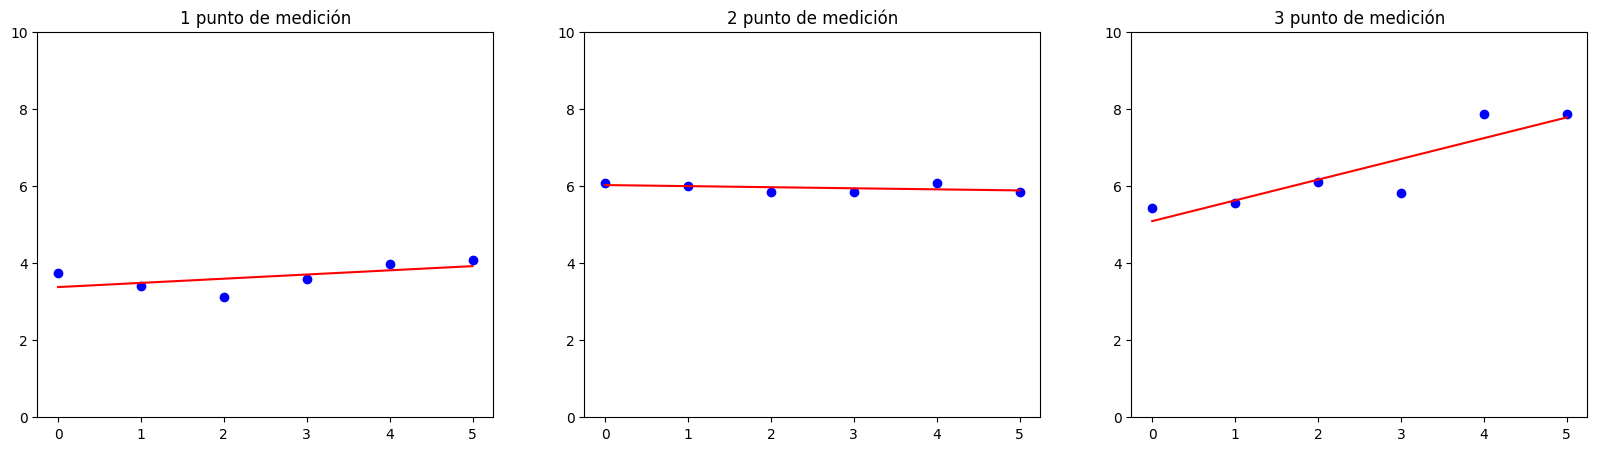

In [53]:
criterio_bool,values = criterio(puntos_de_medición,operario_1,operario_2)

In [64]:
values

,Shapiro-Wilk,Levene test,Durbin Watson
1 punto de medición,0.902892,0.785437,1.297018
2 punto de medición,0.028815,1.000000,2.321062
3 punto de medición,0.047788,0.552184,2.617657


In [26]:
op_1 = puntos_de_medición.loc[puntos_de_medición['Nombre'] == 'Operario 1'] ## Vector con las muestras del operario 1
op_2 = puntos_de_medición.loc[puntos_de_medición['Nombre'] == 'Operario 2'] ## Vector con las muestras del operario

In [27]:
resultados_normales, resultados_no_normales = p_or_np(criterio_bool,puntos_de_medición,op_1,op_2)
# falta f critico
# h y k de mandel y grubbs si se identifica atipico en grubbs, cochran

Resultado para: 1 punto de medición
   Source        SS  DF        MS         F     p-unc       np2    F crit
0  Nombre  0.308267   1  0.308267  3.748126  0.124949  0.483746  7.708647
1  Within  0.328982   4  0.082246       NaN       NaN       NaN  7.708647
Resultado para: 2 punto de medición
MannwhitneyuResult(statistic=5.5, pvalue=1.0)
Resultado para: 3 punto de medición
MannwhitneyuResult(statistic=1.0, pvalue=0.2)


## Documento Word

In [55]:
!pip install python-docx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
values.shape[0]+1

4

In [89]:
from docx import Document
from docx.shared import Cm

# Creación del documento
document = Document()

# Añadimos un titulo al documento, a nivel 0
document.add_heading('Comparación intralaboratorio', 0)

# Añadimos un párrafo
p = document.add_paragraph('El contenido de los párrafos se añadir en varias líneas. ')
p.add_run('Pudiéndose configurar que el texto tenga formato tipo ')
p.add_run('negrita').bold = True
p.add_run(' o ')
p.add_run('itálica.').italic = True

# Para indicar subtitulo se indica el nivel 1
document.add_heading('Objetivo', level=1)

m = document.add_paragraph('El propósito de este documento es el de informar los ')
m.add_run('resultados obtenidos en la verificación de los métodos ') 
m.add_run('normalizados para la calibración de instrumentos de medición ')
m.add_run('en la magnitud de par torsional, como parte del ')
m.add_run('proceso que se lleva a cabo para asegurar la aplicabilidad y ') 
m.add_run('el desempeño de los mismos, entre operarios del laboratorio.')


# Resultados objetivos
document.add_heading('Resultados', level=1)
document.add_picture('/content/Regresion lineal.png', width = Cm(17))

# Imágenes
# document.add_heading('Imágenes', level=1)

# Tablas
document.add_heading('Resultados tablas', level=1)
t = document.add_table(values.shape[0]+1, values.shape[1]+1)

# add the header rows.
for j in range(values.shape[-1]):
    t.cell(0,j+1).text = values.columns[j]
    t.cell(j+1,0).text = values.index[j]


# add the rest of the data frame
for i in range(values.shape[0]):
    print(i)
    for j in range(values.shape[-1]):
        print(j)
        t.cell(i+1,j+1).text = str(values.values[i,j])


document.save('ejemplo.docx')
#document.add_paragraph('Uno', style='List Number')
#document.add_paragraph('Dos', style='List Number')
#document.add_paragraph('Tres', style='List Number')

#document.add_paragraph('O viñetas')
#document.add_paragraph('Manzana', style='List Bullet') 
#document.add_paragraph('Pera', style='List Bullet')
#document.add_paragraph('Naranja', style='List Bullet')

# Imágenes
#document.add_heading('Imágenes', level=1)
#document.add_picture('analytics_lane.jpg', width=Cm(5))

# Tablas
#document.add_heading('Tablas', level=1)

#data = (('Manzana', 12), ('Pera', 5), ('Naranja', 12))

#table = document.add_table(rows=1, cols=2)

#table.rows[0].cells[0].text = 'Fruta'
#table.rows[0].cells[1].text = 'Cantidad'

#for prod, numbr in data:
#    row_cells = table.add_row().cells
#    row_cells[0].text = prod
#    row_cells[1].text = str(numbr)

#document.save('ejemplo.docx')

0
0
1
2
1
0
1
2
2
0
1
2
